In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from google.colab import drive
from tqdm import tqdm

In [6]:
#1. mount drive
try:
    drive.mount('/content/drive')
    print("Drive mounted successfully.")
except Exception as e:
    print("Error mounting drive:", e)

Mounted at /content/drive
Drive mounted successfully.


In [7]:
# 2. Loading and preprocessing image
DATASET_PATH = "/content/drive/MyDrive/animal_dataset"

def load_images(path):
    images = []
    labels = []

    try:
        classes = sorted(os.listdir(path))
    except Exception as e:
        print("Could not read dataset folder:", e)
        return [], []

    print("Classes found:", classes)

    for class_name in classes:
        class_folder = os.path.join(path, class_name)

        try:
            filenames = os.listdir(class_folder)
        except Exception as e:
            print(f"Error reading folder {class_folder}:", e)
            continue

        for f in tqdm(filenames, desc=f"Loading {class_name}"):
            try:
                img_path = os.path.join(class_folder, f)
                img = cv2.imread(img_path)

                if img is None:
                    print("Could not read:", img_path)
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(gray, (32, 32))
                flat = resized.flatten()

                images.append(flat)
                labels.append(classes.index(class_name))

            except Exception as e:
                print(f"Error processing image {f}:", e)

    return np.array(images), np.array(labels)


X, y = load_images(DATASET_PATH)
print("Total samples loaded:", len(X))

# Shuffle dataset so cat/dog/panda appear randomly
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

Classes found: ['cat', 'dog', 'panda']


Loading panda: 100%|██████████| 100/100 [00:04<00:00, 20.19it/s]

Total samples loaded: 300


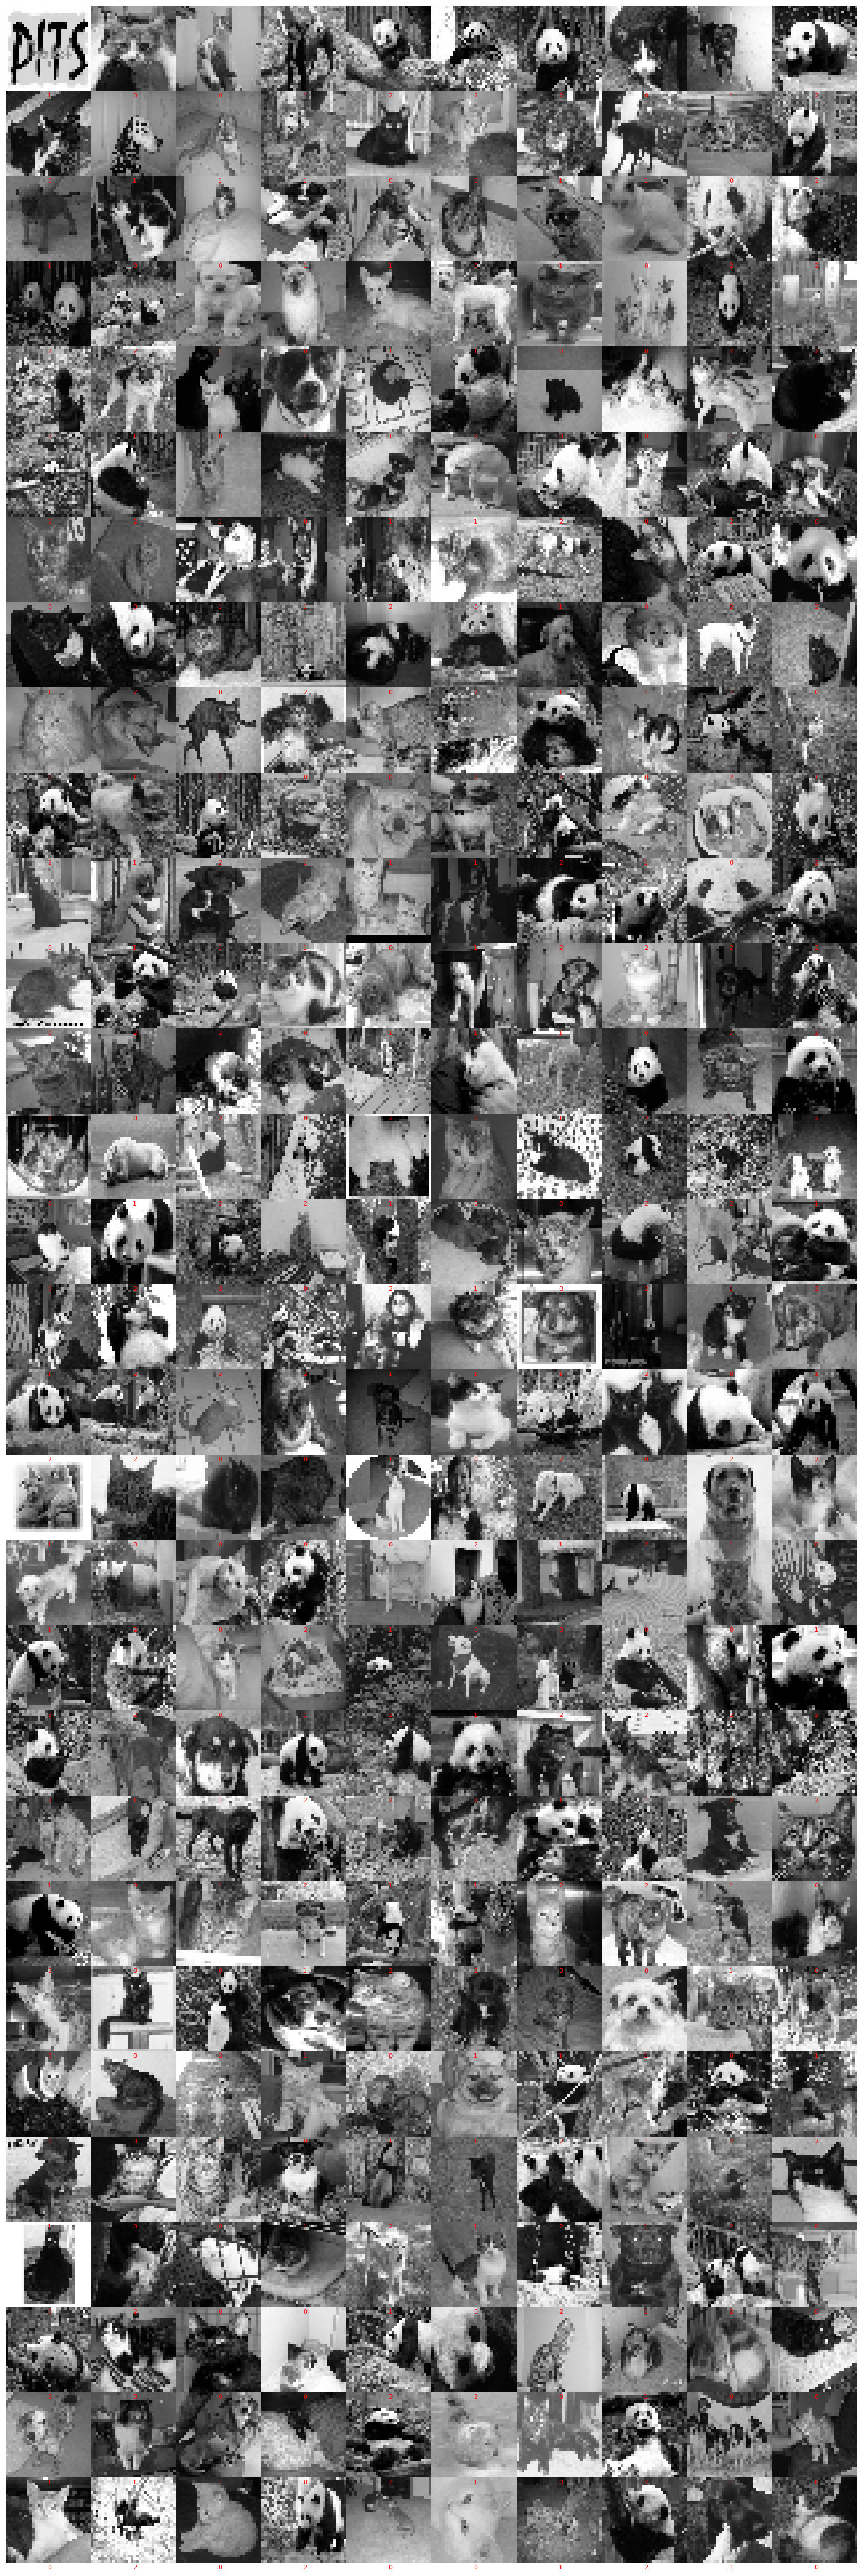

In [8]:
def show_images_grid(X, y, images_per_row=10):
    """Display all images in a single grid with labels."""
    num_images = len(X)
    rows = (num_images + images_per_row - 1) // images_per_row
    img_h, img_w = 32, 32

    grid_image = np.zeros((rows * img_h, images_per_row * img_w), dtype=np.uint8)

    for idx, (img, label) in enumerate(zip(X, y)):
        row = idx // images_per_row
        col = idx % images_per_row
        grid_image[row*img_h:(row+1)*img_h, col*img_w:(col+1)*img_w] = img.reshape(img_h, img_w)

    plt.figure(figsize=(20, rows*2))
    plt.imshow(grid_image, cmap="gray")


    for idx, label in enumerate(y):
        row = idx // images_per_row
        col = idx % images_per_row
        plt.text(col*img_w + img_w//2, row*img_h + img_h + 2, str(label),
                 color="red", fontsize=8, ha="center")

    plt.axis("off")
    plt.show()

show_images_grid(X, y, images_per_row=10)


In [9]:
# 3. DISTANCE FUNCTIONS

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

In [10]:
# 4. k-NN CLASSIFIER
def knn_predict(X_train, y_train, x_test, k, distance_type="L2"):
    distances = []

    for i in range(len(X_train)):
        try:
            if distance_type == "L1":
                d = manhattan_distance(x_test, X_train[i])
            else:
                d = euclidean_distance(x_test, X_train[i])
            distances.append((d, y_train[i]))
        except Exception as e:
            print("Error computing distance:", e)

    distances.sort(key=lambda x: x[0])
    k_labels = [label for (_, label) in distances[:k]]

    try:
        return max(set(k_labels), key=k_labels.count)
    except Exception as e:
        print("Error finding majority label:", e)
        return k_labels[0]

In [11]:
# 5. CROSS VALIDATION

def cross_validation(X, y, k_values, distance_type):
    n = len(X)
    fold_size = n // 5

    fold_wise = []

    for fold in range(5):
        start = fold * fold_size
        end = start + fold_size

        X_val = X[start:end]
        y_val = y[start:end]

        X_train = np.concatenate((X[:start], X[end:]))
        y_train = np.concatenate((y[:start], y[end:]))

        fold_acc_k = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k, distance_type)
                if pred == y_val[i]:
                    correct += 1

            fold_acc_k.append(correct / len(X_val))

        fold_wise.append(fold_acc_k)

    return np.array(fold_wise)


In [12]:
# 6. RUN CROSS VALIDATION

k_values = [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19]

l1_folds = cross_validation(X, y, k_values, "L1")
l2_folds = cross_validation(X, y, k_values, "L2")

avg_l1 = np.mean(l1_folds, axis=0)
avg_l2 = np.mean(l2_folds, axis=0)


print("L1 Accuracy:", avg_l1)
print("L2 Accuracy:", avg_l2)

# percentages
avg_l1_percent = avg_l1 * 100
avg_l2_percent = avg_l2 * 100


print("Average Accuracy for Manhattan (L1) Distance:")
for k, acc in zip(k_values, avg_l1_percent):
    print(f"K = {k:2d} → Accuracy = {acc:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for k, acc in zip(k_values, avg_l2_percent):
    print(f"K = {k:2d} → Accuracy = {acc:.2f}%")


L1 Accuracy: [0.41333333 0.36666667 0.38666667 0.37       0.40666667 0.36666667
 0.4        0.39333333 0.41       0.40666667 0.4       ]
L2 Accuracy: [0.35       0.34333333 0.40333333 0.39666667 0.39666667 0.41
 0.41333333 0.42666667 0.41666667 0.43666667 0.44666667]
Average Accuracy for Manhattan (L1) Distance:
K =  1 → Accuracy = 41.33%
K =  2 → Accuracy = 36.67%
K =  3 → Accuracy = 38.67%
K =  5 → Accuracy = 37.00%
K =  7 → Accuracy = 40.67%
K =  9 → Accuracy = 36.67%
K = 11 → Accuracy = 40.00%
K = 13 → Accuracy = 39.33%
K = 15 → Accuracy = 41.00%
K = 17 → Accuracy = 40.67%
K = 19 → Accuracy = 40.00%

Average Accuracy for Euclidean (L2) Distance:
K =  1 → Accuracy = 35.00%
K =  2 → Accuracy = 34.33%
K =  3 → Accuracy = 40.33%
K =  5 → Accuracy = 39.67%
K =  7 → Accuracy = 39.67%
K =  9 → Accuracy = 41.00%
K = 11 → Accuracy = 41.33%
K = 13 → Accuracy = 42.67%
K = 15 → Accuracy = 41.67%
K = 17 → Accuracy = 43.67%
K = 19 → Accuracy = 44.67%


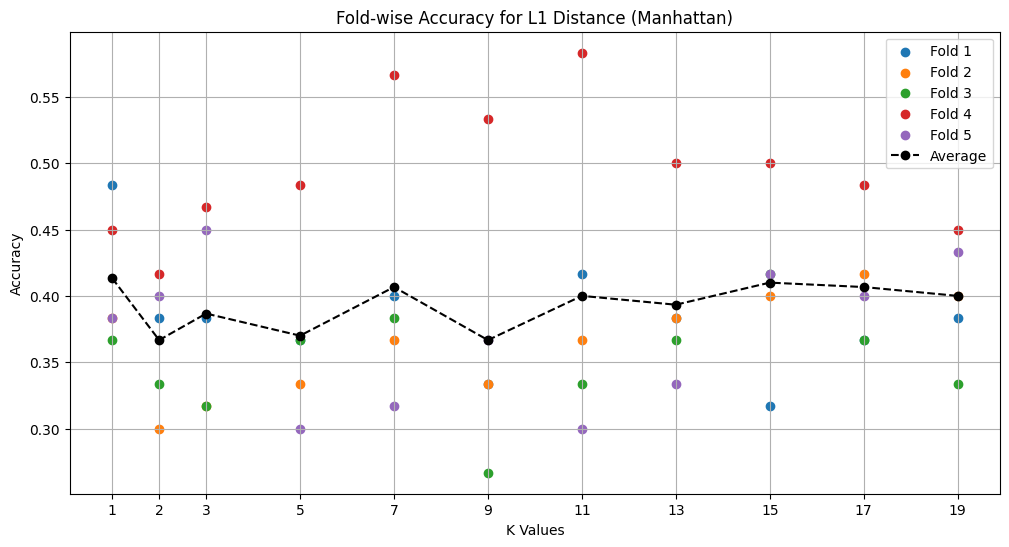

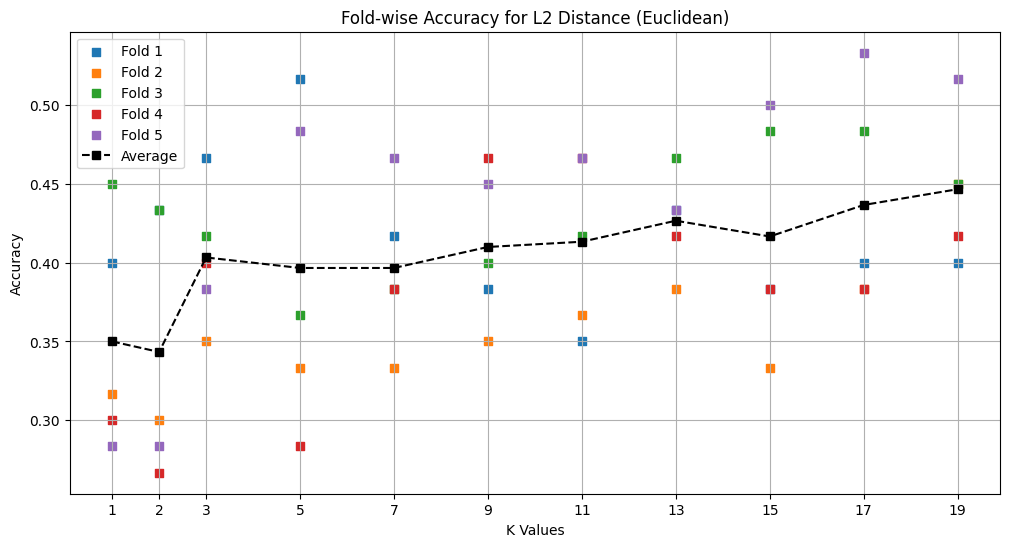

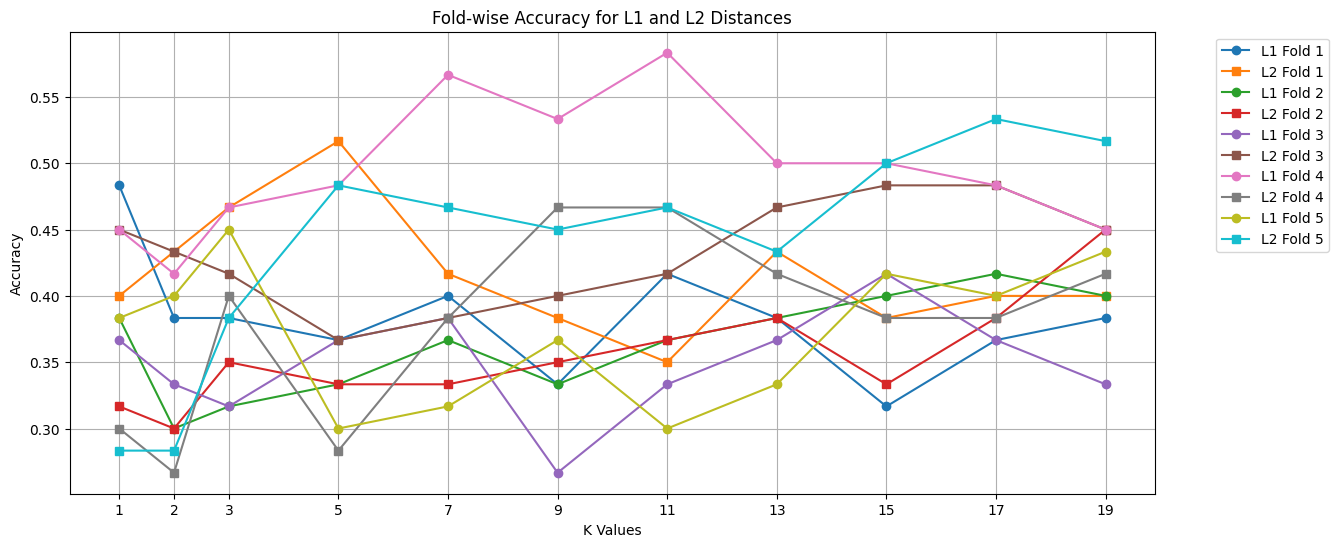

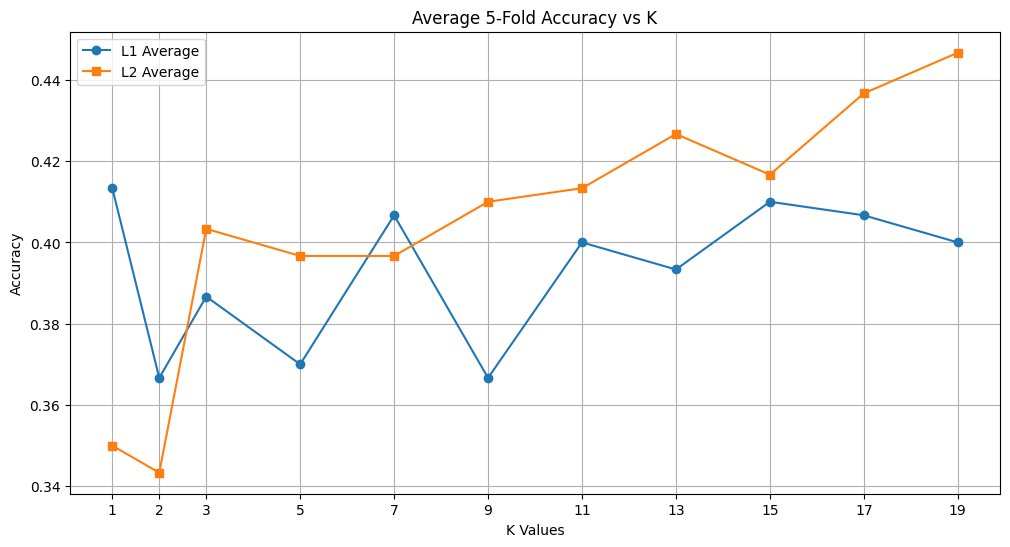

In [13]:
#7. Graph Plotting
# ----------------- L1 Graph -----------------#
plt.figure(figsize=(12, 6))
for f in range(5):
    plt.scatter(k_values, l1_folds[f], marker='o', label=f"Fold {f+1}")
plt.plot(k_values, avg_l1, marker='o', linestyle='--', color='black', label="Average")

plt.title("Fold-wise Accuracy for L1 Distance (Manhattan)")
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.legend()
plt.show()


# ----------------- L2 Graph -----------------#
plt.figure(figsize=(12, 6))
for f in range(5):
    plt.scatter(k_values, l2_folds[f], marker='s', label=f"Fold {f+1}")
plt.plot(k_values, avg_l2, marker='s', linestyle='--', color='black', label="Average")

plt.title("Fold-wise Accuracy for L2 Distance (Euclidean)")
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.legend()
plt.show()


# ----------------- Merged Graph -----------------#
plt.figure(figsize=(14, 6))
for f in range(5):
    plt.plot(k_values, l1_folds[f], marker='o', label=f"L1 Fold {f+1}")
    plt.plot(k_values, l2_folds[f], marker='s', label=f"L2 Fold {f+1}")

plt.title("Fold-wise Accuracy for L1 and L2 Distances")
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(k_values, avg_l1, marker='o', label="L1 Average")
plt.plot(k_values, avg_l2, marker='s', label="L2 Average")
plt.title("Average 5-Fold Accuracy vs K")
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.legend()
plt.show()


DISCUSSION:

Performance Comparison (L1 vs L2 Distance):

Across most values of K, the results showed a noticeable difference in performance between L1 and L2 distances.

Euclidean (L2) distance generally achieved higher average accuracy because it emphasizes larger pixel differences and better captures the geometric structure of image data.

Manhattan (L1) distance performed slightly worse because it treats all pixel differences equally and does not account for the magnitude of variations as effectively as L2.

Dataset Characteristics and Their Impact:

Images contain continuous pixel intensity values (0–255), which are well suited for L2 distance calculations.

Downscaling to 32×32 reduced complexity, meaning that subtle differences between animals (ears, fur texture, shape) remain detectable but not overly detailed.

Three visually distinct classes (cat, dog, panda) benefit more from a distance metric that captures larger structural differences—again favoring L2.

Limitations:

Manual grayscale processing may not perfectly preserve fine image details.

Using raw pixel intensities makes k-NN sensitive to lighting variations and background clutter.

No augmentation or noise reduction was applied, which could make L1 and L2 sensitive to irrelevant variations in images.

k-NN becomes slower with larger datasets, since every prediction requires comparing all images.


===== TOP 5 PREDICTIONS =====

Image 1: Actual = Dog, Predicted = Dog
Image 2: Actual = Cat, Predicted = Cat
Image 3: Actual = Cat, Predicted = Cat
Image 4: Actual = Dog, Predicted = Dog
Image 5: Actual = Panda, Predicted = Panda


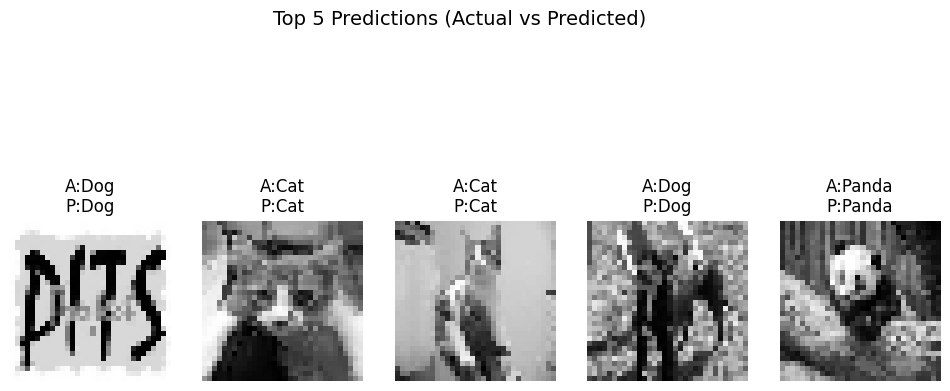

In [14]:
# 8. TOP 5 PREDICTIONS

def show_top5_predictions(X, y, k=3, distance="L2"):
    plt.figure(figsize=(12, 6))

    class_names = ["Cat", "Dog", "Panda"]

    print("\n===== TOP 5 PREDICTIONS =====\n")

    for i in range(5):
        try:
            pred = knn_predict(X, y, X[i], k, distance)


            print(f"Image {i+1}: Actual = {class_names[y[i]]}, Predicted = {class_names[pred]}")


            plt.subplot(1, 5, i+1)
            plt.imshow(X[i].reshape(32, 32), cmap="gray")
            plt.title(f"A:{class_names[y[i]]}\nP:{class_names[pred]}")
            plt.axis("off")

        except Exception as e:
            print("Error predicting sample:", e)

    plt.suptitle("Top 5 Predictions (Actual vs Predicted)", fontsize=14)
    plt.show()


show_top5_predictions(X, y, k=3, distance="L2")
